# Netflixを超えていけ！Contextual Banditアルゴリズムを徹底解説！(Part 2)

In [2]:
import numpy as np
import pandas as pd

from sklearn.ensemble import GradientBoostingRegressor as GBR, GradientBoostingClassifier as GBC

from pandas import DataFrame
from plotly.offline import iplot, plot
from plotly.graph_objs import Bar, Figure, Layout

In [3]:
from pymab.bandit import GaussianBandit
from pymab.evaluation import DataGenerator, ReplayMethod, DirectMethod, IPSEstimator, DREstimator, MRDREstimator
from pymab.policy import LinUCB, LinTS, LogisticTS
from pymab.sim import BanditSimulator

## Off-Policy Evaluation実験2

### 設定
- アーム数は10, 文脈の次元は20次元のバンディットに対する報酬最適化
- **LinUCB($\alpha=1$)**によって集められたデータ数5万のログデータによるOPE
- 用いる評価指標は実験1で使ったものに加えて, IPS, DR, MRDR（予測モデルには勾配ブースティングを使用）
- 評価指標の性能は各Policyの真の性能と推定された性能の相対誤差によって評価

## Data Generation

In [4]:
n_arms, n_features = 10, 20
gb = GaussianBandit(n_arms=n_arms, n_features=n_features, scale=0.01, noise=0.01, contextual=True)
dg = DataGenerator(policy=LinTS(n_arms=n_arms, n_features=n_features, sigma=1, sample_batch=20, batch_size=1), 
                   bandit=gb,
                   n_rounds=50000, 
                   randomized=False)

In [5]:
data, a, r = dg.generate_data()

## Policy Candidates

- $\pi^{new}$の候補

In [6]:
pols =  [LinUCB(n_arms=n_arms, n_features=n_features, alpha=0.1, batch_size=1),
         LinUCB(n_arms=n_arms, n_features=n_features, alpha=0.01, batch_size=1),
         LinUCB(n_arms=n_arms, n_features=n_features, alpha=1, batch_size=1),
         LinUCB(n_arms=n_arms, n_features=n_features, alpha=10, batch_size=1),
         LinTS(n_arms=n_arms, n_features=n_features, sigma=0.01, sample_batch=20, batch_size=1)]

## Replay Method

In [7]:
rm = ReplayMethod(policy_list=pols, n_iter=1)
result_rm = rm.estimate(data, a, r)
result_rm.describe()

,LinUCB(α=0.1),LinUCB(α=0.01),LinUCB(α=1),LinUCB(α=10),LinTS(σ=0.01)
count,1.000000,1.000000,1.000000,1.000000,1.000000
mean,0.527774,0.526439,0.534469,0.194483,0.538116
std,NaN,NaN,NaN,NaN,NaN
min,0.527774,0.526439,0.534469,0.194483,0.538116
25%,0.527774,0.526439,0.534469,0.194483,0.538116
50%,0.527774,0.526439,0.534469,0.194483,0.538116
75%,0.527774,0.526439,0.534469,0.194483,0.538116
max,0.527774,0.526439,0.534469,0.194483,0.538116


## Direct Method

In [8]:
dm = DirectMethod(policy_list=pols, n_iter=1, regression=True)
dm.fit(pom=GBR(n_estimators=100, max_depth=5, learning_rate=0.3), X=data, a=a, r=r)
result_dm = dm.estimate(data, a, r)
result_dm.describe()

,LinUCB(α=0.1),LinUCB(α=0.01),LinUCB(α=1),LinUCB(α=10),LinTS(σ=0.01)
count,1.00000,1.000000,1.000000,1.000000,1.000000
mean,0.48703,0.424615,0.478451,0.404788,0.441528
std,NaN,NaN,NaN,NaN,NaN
min,0.48703,0.424615,0.478451,0.404788,0.441528
25%,0.48703,0.424615,0.478451,0.404788,0.441528
50%,0.48703,0.424615,0.478451,0.404788,0.441528
75%,0.48703,0.424615,0.478451,0.404788,0.441528
max,0.48703,0.424615,0.478451,0.404788,0.441528


## IPS Estimator

In [9]:
ips = IPSEstimator(policy_list=pols, n_iter=1)
ips.fit(pse=GBC(n_estimators=100, max_depth=5, learning_rate=0.3), 
        X=data, a=a)
result_ips = ips.estimate(data, a, r)
result_ips.describe()

,LinUCB(α=0.1),LinUCB(α=0.01),LinUCB(α=1),LinUCB(α=10),LinTS(σ=0.01)
count,1.000000,1.000000,1.00000,1.000000,1.000000
mean,0.631808,1.130421,0.62371,-5.245263,1.302448
std,NaN,NaN,NaN,NaN,NaN
min,0.631808,1.130421,0.62371,-5.245263,1.302448
25%,0.631808,1.130421,0.62371,-5.245263,1.302448
50%,0.631808,1.130421,0.62371,-5.245263,1.302448
75%,0.631808,1.130421,0.62371,-5.245263,1.302448
max,0.631808,1.130421,0.62371,-5.245263,1.302448


## DR Estimator

In [10]:
dr = DREstimator(policy_list=pols, n_iter=1, regression=True)
dr.fit(pom=GBR(n_estimators=100, max_depth=5, learning_rate=0.3), 
       pse=GBC(n_estimators=100, max_depth=5, learning_rate=0.3), 
       X=data, a=a, r=r)
result_dr = dr.estimate(data, a, r)
result_dr.describe()

,LinUCB(α=0.1),LinUCB(α=0.01),LinUCB(α=1),LinUCB(α=10),LinTS(σ=0.01)
count,1.000000,1.000000,1.000000,1.000000,1.000000
mean,0.486285,0.486598,0.478608,0.405626,0.440357
std,NaN,NaN,NaN,NaN,NaN
min,0.486285,0.486598,0.478608,0.405626,0.440357
25%,0.486285,0.486598,0.478608,0.405626,0.440357
50%,0.486285,0.486598,0.478608,0.405626,0.440357
75%,0.486285,0.486598,0.478608,0.405626,0.440357
max,0.486285,0.486598,0.478608,0.405626,0.440357


## MRDR Estimator

In [11]:
mrdr = MRDREstimator(policy_list=pols, n_iter=1, regression=True)
mrdr.fit(pom=GBR(n_estimators=100, max_depth=5, learning_rate=0.3), 
         pse=GBC(n_estimators=100, max_depth=5, learning_rate=0.3), 
         X=data, a=a, r=r)
result_mrdr = mrdr.estimate(data, a, r)
result_mrdr.describe()

,LinUCB(α=0.1),LinUCB(α=0.01),LinUCB(α=1),LinUCB(α=10),LinTS(σ=0.01)
count,1.000000,1.000000,1.000000,1.000000,1.000000
mean,0.487079,0.480957,0.478853,0.402998,0.438713
std,NaN,NaN,NaN,NaN,NaN
min,0.487079,0.480957,0.478853,0.402998,0.438713
25%,0.487079,0.480957,0.478853,0.402998,0.438713
50%,0.487079,0.480957,0.478853,0.402998,0.438713
75%,0.487079,0.480957,0.478853,0.402998,0.438713
max,0.487079,0.480957,0.478853,0.402998,0.438713


## Online

In [12]:
gb_online = GaussianBandit(n_arms=n_arms, n_features=n_features, scale=0.01, noise=0.01, contextual=True)
gb_online.params = gb.params

In [19]:
n_sims, n_rounds = 30, 10000
bs = BanditSimulator(policy_list=pols, 
                     bandit=gb_online, 
                     num_sims=n_sims, n_rounds=n_rounds, contextual=True)

In [ ]:
bs.run_sim()

In [25]:
rewards_plot, regret_plot, bingo_plot = bs.plots()

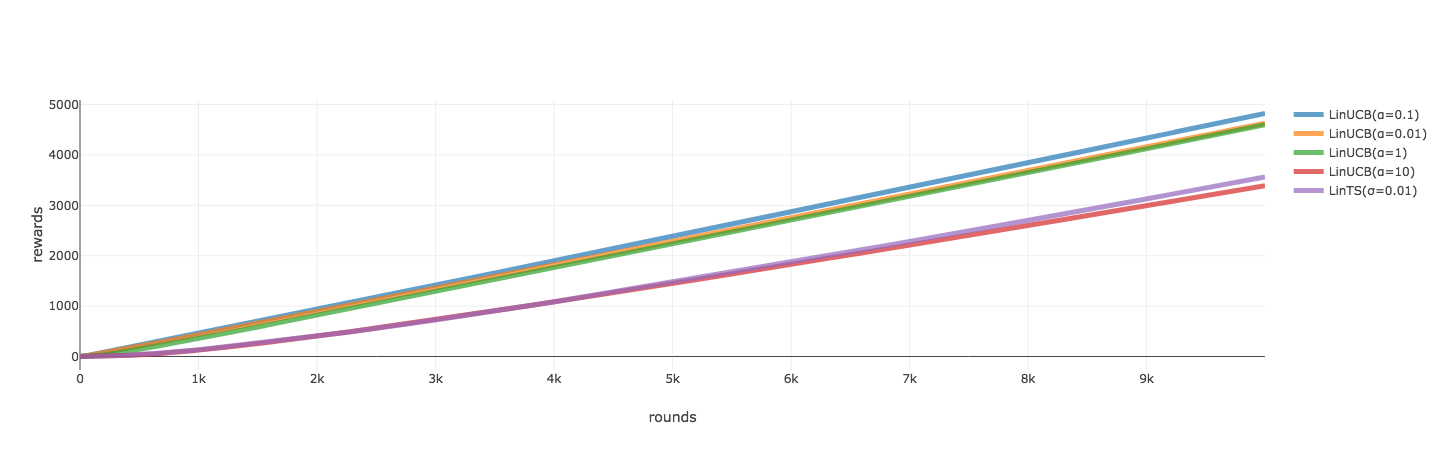

In [26]:
iplot(rewards_plot)

## Plot

In [27]:
true_rewards = np.array([bs.result_list[i].rewards.mean(level="rounds").values[-1] for i in np.arange(len(bs.result_list))]) / n_rounds
estimated_rewards = np.array([df.describe().loc["mean", :].tolist() for df in [result_rm, result_dm, result_ips, result_dr, result_mrdr]])

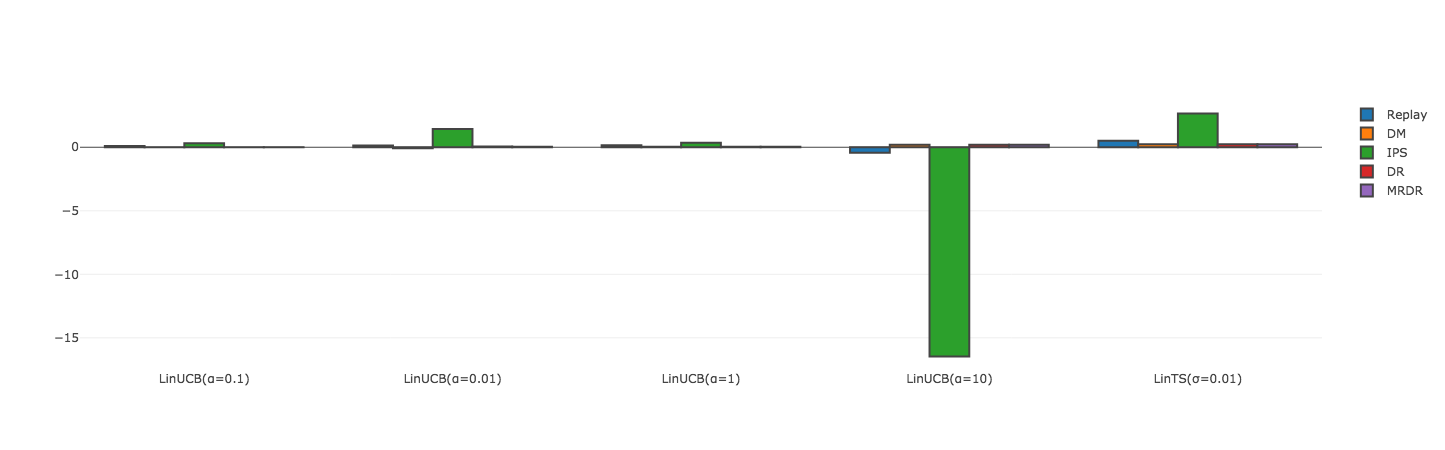

In [28]:
pol_names, est_names = [pol.name for pol in pols], ["Replay", "DM", "IPS", "DR", "MRDR"]
bars = [Bar(x=pol_names, y=(est - true_rewards) / np.abs(true_rewards), marker=dict(line=dict(width=2)), name=est_name) for est, est_name in zip(estimated_rewards, est_names)]
layout = Layout(barmode='group')
fig = Figure(data=bars, layout=layout)
iplot(fig)